## Adversarial Domain Adaptation

I've tried WGAN-div/WGAN-GP with several CNN structures (generator/discriminator/classifier) and found that it is really hard to successfully trained.

Finally, I used the dnn structure in the following github and with vanilla gan and adam instead of rmsprop, then good result is obtained. Also, I found that training is failed with batch normalization in vanilla gan.

https://github.com/lancerane/Adversarial-domain-adaptation/blob/master/Domain%20adaptation%2C%20TF2.0.ipynb

In summary, I felt that GAN is harder than I expected even using WGAN-div/WGAN-GP and some stratigies like updating few iterations of discriminator then one iteration of generator.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import Model
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
import pickle, time
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
print(tf.__version__)

2.1.0


## A. Data loading

In [2]:
data = pickle.load(open('mnistm/mnistm_data.pkl','rb'))
x_mnistm_train, y_mnistm_train = data['train']
x_mnistm_valid, y_mnistm_valid = data['valid']
tgt_imgs_test, tgt_labels_test = data['test']
tgt_imgs = np.concatenate((x_mnistm_train,x_mnistm_valid))/255.0 - 0.5
print('tgt_imgs.shape={}'.format(tgt_imgs.shape))
tgt_labels = np.concatenate((y_mnistm_train,y_mnistm_valid))
print('tgt_labels.shape={}'.format(tgt_labels.shape))

tgt_imgs, tgt_labels = shuffle(tgt_imgs, tgt_labels)

tgt_imgs_test = tgt_imgs_test/255.0 - 0.5
print('tgt_imgs_test.shape={}'.format(tgt_imgs_test.shape))

tgt_imgs.shape=(60000, 28, 28, 3)
tgt_labels.shape=(60000,)
tgt_imgs_test.shape=(10000, 28, 28, 3)


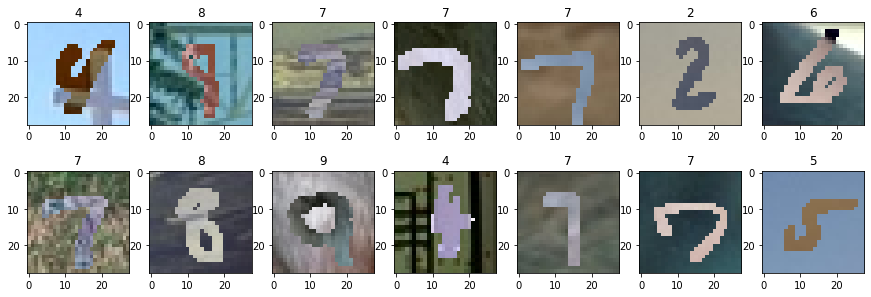

In [3]:
plt.figure(figsize=(15,5))
for i in np.arange(2*7):
    random_idx = np.random.randint(0,len(tgt_imgs))
    plt.subplot(2,7,i+1)
    plt.imshow(tgt_imgs[random_idx].reshape(28,28,3)+0.5)
    plt.title(tgt_labels[random_idx])

In [4]:
mnist = tf.keras.datasets.mnist
(src_imgs, src_labels), (src_imgs_test, src_labels_test) = mnist.load_data()
src_imgs, src_labels = shuffle(src_imgs, src_labels)
src_imgs = src_imgs/255.0 - 0.5
src_imgs_test = src_imgs_test/255.0 - 0.5
src_imgs = np.stack((src_imgs,src_imgs,src_imgs),axis=-1)
src_imgs_test = np.stack((src_imgs_test,src_imgs_test,src_imgs_test),axis=-1)

print("src_imgs.shape = ",src_imgs.shape,"; min = ",np.min(src_imgs),"; max = ",np.max(src_imgs))
print("src_imgs_test.shape = ",src_imgs_test.shape,"; min = ",np.min(src_imgs_test),"; max = ",np.max(src_imgs_test))

_, h, w, c = src_imgs.shape

src_imgs.shape =  (60000, 28, 28, 3) ; min =  -0.5 ; max =  0.5
src_imgs_test.shape =  (10000, 28, 28, 3) ; min =  -0.5 ; max =  0.5


In [5]:
BSIZE = 64

src_ds = tf.data.Dataset.from_tensor_slices((src_imgs, src_labels))
tgt_ds = tf.data.Dataset.from_tensor_slices((tgt_imgs, tgt_labels))
# print(len(list(src_ds.as_numpy_iterator())))
# print(len(list(tgt_ds.as_numpy_iterator())))
train_ds = tf.data.Dataset.zip((src_ds, tgt_ds)).shuffle(512).batch(BSIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
# print(len(list(train_ds.as_numpy_iterator())))

src_ds_test = tf.data.Dataset.from_tensor_slices((src_imgs_test, src_labels_test))
tgt_ds_test = tf.data.Dataset.from_tensor_slices((tgt_imgs_test, tgt_labels_test))
# print(len(list(src_ds_test.as_numpy_iterator())))
# print(len(list(tgt_ds_test.as_numpy_iterator())))
test_ds = tf.data.Dataset.zip((src_ds_test, tgt_ds_test)).batch(BSIZE).prefetch(tf.data.experimental.AUTOTUNE)
# print(len(list(test_ds.as_numpy_iterator())))

In [6]:
# try getting a batch from train_ds
for (src_img, src_label), (tgt_img, tgt_label) in train_ds:
    print(src_img.shape)
    print(src_label)
    print(tgt_img.shape)
    print(tgt_label)
    break

(64, 28, 28, 3)
tf.Tensor(
[8 1 8 5 0 9 1 5 5 0 3 3 3 7 6 1 4 2 7 4 4 3 7 3 9 4 3 1 8 6 3 2 7 2 1 2 9
 3 1 7 4 1 4 7 6 8 9 7 0 7 0 0 6 2 7 0 3 6 8 6 6 7 5 0], shape=(64,), dtype=uint8)
(64, 28, 28, 3)
tf.Tensor(
[7 5 8 8 6 0 3 1 8 2 7 6 3 5 7 3 9 8 5 1 3 6 4 4 9 5 5 4 8 7 3 6 4 3 5 7 0
 2 7 6 0 7 4 5 5 6 8 2 7 7 9 8 9 4 2 2 9 7 2 4 5 8 0 7], shape=(64,), dtype=uint8)


## B. Generator, Discriminator, and Classifier

In [7]:
CLASSNUM = 10

In [8]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__() 
#         self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
        self.conv1 = Conv2D(64, 5, activation='relu')
        self.conv2 = Conv2D(128, 5, activation='relu')
        self.maxpool = MaxPool2D(2)
        self.flatten = Flatten()
    
    def call(self, x):
#         x = self.normalise(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        return self.flatten(x)

In [9]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()   
        self.d3 = Dense(64, activation='relu')
        self.d4 = Dense(1, activation=None)

    def call(self, feats):
        feats = self.d3(feats)
    
        return self.d4(feats)

In [10]:
class Classifier(Model):
    def __init__(self):
        super(Classifier, self).__init__() 
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(CLASSNUM, activation=None)
    

    def call(self, feats):  
        feats = self.d1(feats)

        return self.d2(feats)

In [11]:
generator = Generator()
discriminator = Discriminator()
classifier = Classifier()

## C. Training on Source Domain

In [12]:
classifier_loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier_train_loss = tf.keras.metrics.Mean(name='train_loss')
classifier_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

classifier_test_loss = tf.keras.metrics.Mean(name='test_loss')
classifier_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
# better than rmsprop, and 1e-3 is better than 1e-4
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [15]:
gradient_penalty_weight = 1.0
@tf.function
def train_dis_step(src_images, tgt_images):
    with tf.GradientTape() as disc_tape:
        src_feats = generator(src_images, training=True)
        src_output = discriminator(src_feats, training=True)
        tgt_feats = generator(tgt_images, training=True)
        tgt_output = discriminator(tgt_feats, training=True)
        disc_loss = discriminator_loss(src_output, tgt_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
@tf.function
def train_gen_step(batch_img, batch_label, tgt_images):
    with tf.GradientTape() as gen_tape:
        feats = generator(batch_img, training=True)
        logits = classifier(feats, training=True)
        preds = tf.nn.softmax(logits=logits)
        classifier_loss = classifier_loss_object(batch_label, logits)
        
        tgt_feats = generator(tgt_images, training=True)
        tgt_output = discriminator(tgt_feats, training=True)
        gen_loss = generator_loss(tgt_output)
        
        loss = gen_loss + 30.0*classifier_loss

    update_vars = generator.trainable_variables + classifier.trainable_variables
    gradients = gen_tape.gradient(loss, update_vars)
    generator_optimizer.apply_gradients(zip(gradients, update_vars))
    classifier_train_loss(classifier_loss)
    classifier_train_accuracy(batch_label, preds)

In [17]:
@tf.function
def train_gan_step(src_images, tgt_images):
    train_dis_step(src_images, tgt_images)
    train_gen_step(tgt_images)

@tf.function
def test_step(images, labels):
    feats = generator(images, training=False)
    logits = classifier(feats, training=False)
    preds = tf.nn.softmax(logits=logits)
    t_loss = classifier_loss_object(labels, logits)

    classifier_test_loss(t_loss)
    classifier_test_accuracy(labels, preds)


In [18]:
EPOCHS = 100
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    classifier_train_loss.reset_states()
    classifier_train_accuracy.reset_states()
    counter = 0
    for (src_img, src_label), (tgt_img, tgt_label) in train_ds:
        counter += 1
        train_dis_step(src_img, tgt_img)
        train_gen_step(src_img, src_label, tgt_img)
    print('Epoch {}, Train Loss: {}, Train Acc: {}%'.format(epoch+1, classifier_train_loss.result(), classifier_train_accuracy.result()*100))
    
    classifier_test_loss.reset_states()
    classifier_test_accuracy.reset_states()
    for (src_img, src_label), (tgt_img, tgt_label) in test_ds:
        test_step(src_img, src_label)
    print('\tTest Loss: {}, Test Acc: {}%'.format(classifier_test_loss.result(), classifier_test_accuracy.result()*100))
    
    classifier_test_loss.reset_states()
    classifier_test_accuracy.reset_states()
    for (src_img, src_label), (tgt_img, tgt_label) in test_ds:
        test_step(tgt_img, tgt_label)
    print('\tTarget Domain Test Loss: {}, Test Acc: {}%'.format(classifier_test_loss.result(), classifier_test_accuracy.result()*100))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Train Loss: 0.12087215483188629, Train Acc: 96.34638214111328%
	Test Loss: 0.06795348972082138, Test Acc: 97.90999603271484%
	Target Domain Test Loss: 1.1707931756973267, Test Acc: 62.720001220703125%
Epoch 2, Train Loss: 0.06536117941141129, Train Acc: 98.073974609375%
	Test Loss: 0.04793090000748634, Test Acc: 98.54999542236328%
	Target Domain Test Loss: 1.0224483013153076, Test Acc: 68.33999633789062%
Epoch 3, Train Loss: 0.04616449028253555, Train Acc: 98.61426544189453%
	Test Loss: 0.04052

Epoch 37, Train Loss: 0.009641802869737148, Train Acc: 99.87159729003906%
	Test Loss: 0.18235260248184204, Test Acc: 98.94000244140625%
	Target Domain Test Loss: 1.029423475265503, Test Acc: 85.65999603271484%
Epoch 38, Train Loss: 0.015620306134223938, Train Acc: 99.8182373046875%
	Test Loss: 0.172322079539299, Test Acc: 98.94999694824219%
	Target Domain Test Loss: 0.9429594278335571, Test Acc: 86.80999755859375%
Epoch 39, Train Loss: 0.010085543617606163, Train Acc: 99.8732681274414%
	Test Loss: 0.2181704044342041, Test Acc: 98.72999572753906%
	Target Domain Test Loss: 1.2265238761901855, Test Acc: 85.12999725341797%
Epoch 40, Train Loss: 0.011298004537820816, Train Acc: 99.85992431640625%
	Test Loss: 0.18020443618297577, Test Acc: 98.8499984741211%
	Target Domain Test Loss: 1.1521100997924805, Test Acc: 84.70999908447266%
Epoch 41, Train Loss: 0.009607793763279915, Train Acc: 99.8632583618164%
	Test Loss: 0.16351032257080078, Test Acc: 98.94000244140625%
	Target Domain Test Loss: 1.

	Test Loss: 0.33834144473075867, Test Acc: 99.05999755859375%
	Target Domain Test Loss: 2.296797752380371, Test Acc: 85.39999389648438%
Epoch 77, Train Loss: 0.013907364569604397, Train Acc: 99.89827728271484%
	Test Loss: 0.28350797295570374, Test Acc: 99.0%
	Target Domain Test Loss: 2.576972484588623, Test Acc: 84.83000183105469%
Epoch 78, Train Loss: 0.011387290433049202, Train Acc: 99.90328216552734%
	Test Loss: 0.3519628047943115, Test Acc: 98.93000030517578%
	Target Domain Test Loss: 2.27120041847229, Test Acc: 84.83999633789062%
Epoch 79, Train Loss: 0.011846842244267464, Train Acc: 99.91495513916016%
	Test Loss: 0.3334380090236664, Test Acc: 99.06999969482422%
	Target Domain Test Loss: 2.469850540161133, Test Acc: 83.6300048828125%
Epoch 80, Train Loss: 0.011717339046299458, Train Acc: 99.91996002197266%
	Test Loss: 0.3620472550392151, Test Acc: 99.0199966430664%
	Target Domain Test Loss: 2.137877941131592, Test Acc: 84.75%
Epoch 81, Train Loss: 0.009218019433319569, Train Acc: 

In [19]:
@tf.function
def gen_feat(images):
    feats = generator(images, training=False)
    return feats

In [20]:
classifier.variables[-1].device

'/job:localhost/replica:0/task:0/device:GPU:0'

---

### Using tSNE to Plot Embeddings

In [21]:
srcFeats, srcLabels = zip(*[(gen_feat(src_img),src_label) for (src_img, src_label), _ in train_ds])
srcFeats = np.concatenate(srcFeats)
srcFeats = srcFeats[0:-1:10]
srcLabels = np.concatenate(srcLabels)
srcLabels = srcLabels[0:-1:10]
print('srcFeats.shape={}'.format(srcFeats.shape))
print('srcLabels.shape={}'.format(srcLabels.shape))

tgtFeats, tgtLabels = zip(*[(gen_feat(tgt_img),tgt_label) for _, (tgt_img, tgt_label) in train_ds])
tgtFeats = np.concatenate(tgtFeats)
tgtFeats = tgtFeats[0:-1:10]
tgtLabels = np.concatenate(tgtLabels)
tgtLabels = tgtLabels[0:-1:10]
print('tgtFeats.shape={}'.format(tgtFeats.shape))
print('tgtLabels.shape={}'.format(tgtLabels.shape))

featVecs = np.concatenate([srcFeats, tgtFeats])
print('featVecs.shape={}'.format(featVecs.shape))
labels = np.concatenate([srcLabels, tgtLabels])
print('labels.shape={}'.format(labels.shape))

srcFeats.shape=(5997, 12800)
srcLabels.shape=(5997,)
tgtFeats.shape=(5997, 12800)
tgtLabels.shape=(5997,)
featVecs.shape=(11994, 12800)
labels.shape=(11994,)


In [22]:
embedded = TSNE(n_components=2).fit_transform(featVecs)
print(embedded.shape)

(11994, 2)


In [23]:
from matplotlib import pylab

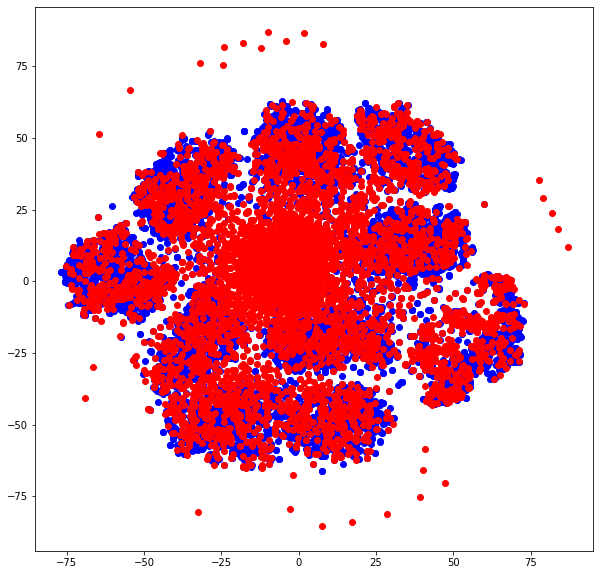

In [24]:
pylab.figure(figsize=(10,10))
for i in np.arange(len(embedded)):
    c = 'r'
    if i<len(embedded)/2:
        c = 'b'
    x, y = (embedded[i,0],embedded[i,1])
    pylab.scatter(x,y,c=c)
    #pylab.annotate(str(Lab[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

In [25]:
emb = embedded
emb.shape

(11994, 2)

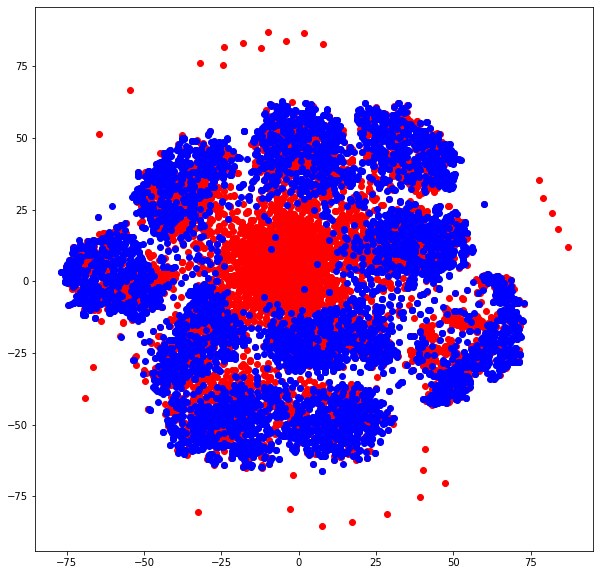

In [26]:
pylab.figure(figsize=(10,10))
for i in np.arange(len(emb)):
    c = 'r'
    j=len(emb)-i-1
    if j<len(emb)/2:
        c = 'b'
    x, y = (emb[j,0],emb[j,1])
    pylab.scatter(x,y,c=c)
    #pylab.annotate(str(Lab[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

In [27]:
# dot colors
cmap=list()
for i in np.arange(10):
    cmap.append(np.random.rand(1,3))
print(cmap[0])
permute_idx = np.random.permutation(10)
cmap = [cmap[i] for i in permute_idx]

[[0.18068263 0.50824596 0.93676066]]


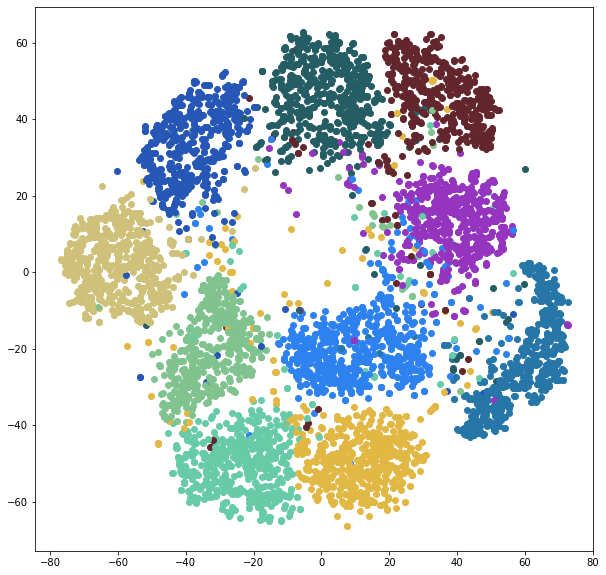

In [28]:
plotNum = len(srcFeats)
pylab.figure(figsize=(10,10))
for i in np.arange(plotNum):
    x, y = (embedded[i,0],embedded[i,1])
    pylab.scatter(x,y,c=cmap[labels[i]])
    #pylab.annotate(str(Lab[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

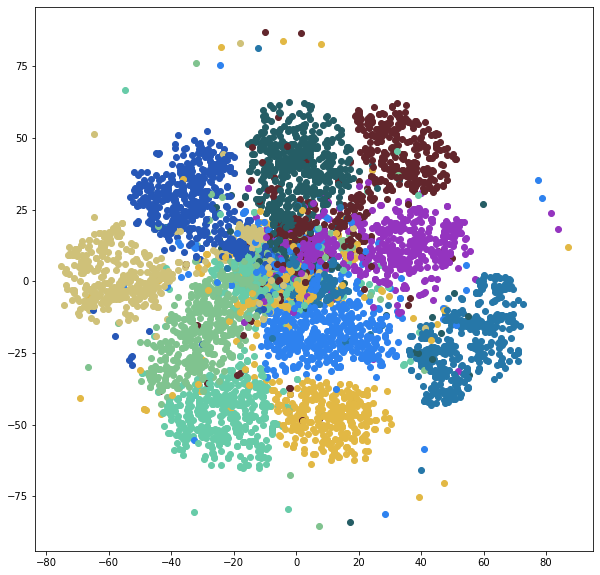

In [29]:
plotNum = len(tgtFeats)
pylab.figure(figsize=(10,10))
for i in np.arange(plotNum):
    x, y = (embedded[i+plotNum,0],embedded[i+plotNum,1])
    pylab.scatter(x,y,c=cmap[labels[i+plotNum]])
    #pylab.annotate(str(Lab[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()